# General

## Mount Google Drive

In [1]:
from google.colab import drive #mount Google Drive
drive.mount('/gdrive')

Mounted at /gdrive


## Imports

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
import os
import sys
import logging
import time
import h5py
import math

## Set Paths

In [3]:
# set root dir: the path to the github repo folder "XAI_spec_TSC" in your google drive
root_dir = '/gdrive/My Drive/Xplainable AI - Univariate Time Series - spectrograms/'

paths = {
    'root': root_dir,
    'dataset': os.path.join(root_dir,'AudioMNIST-master'),
    'data': os.path.join(root_dir,'AudioMNIST-master/data'),
    'meta': os.path.join(root_dir,'AudioMNIST-master/data/audioMNIST_meta.txt'),
    'spectrograms': os.path.join(root_dir,'spectrograms'),
    'splits': os.path.join(root_dir,'splits'),
    'results': os.path.join(root_dir, 'results'),
    'models': os.path.join(root_dir, 'results/models'),
    'history': os.path.join(root_dir, 'results/history'),
    'evaluation': os.path.join(root_dir, 'results/evaluation'),
    'xai': os.path.join(root_dir, 'results/xai'),
    'plots': os.path.join(root_dir, 'results/plots'),
    'plots_waveform': os.path.join(root_dir, 'results/plots/waveform'),
    'plots_spectrograms': os.path.join(root_dir, 'results/plots/spectrograms')
}

# labels and number of splits
labels = ['gender','digit']
splits = 5

# append the directory to the python path using sys in order to make the seperate py files importable
sys.path.append(root_dir)

## Utils

In [4]:
########## 1. function to write log about the events
def write_log(message):
    logging.basicConfig(level = logging.INFO, filename=os.path.join(root_dir,'events.log'), filemode='a', format='%(asctime)s - %(message)s')
    logging.info(message)
    print(message) 


########## 2. function to create a directory
def create_directory(directory_path):
    if os.path.isdir(directory_path) == False:
        os.mkdir(directory_path)
        write_log('Created folder: '+directory_path)
    #else:
        #writeLog('Folder already exists: '+directory_path)

########## 3. function to calculate time difference between two timepoints from package 'time' and returns the duration in format HH:MM:SS as String
def get_duration(start_time,end_time):
    duration = round(end_time-start_time)
    if duration < 0:
        duration*=-1
    h=math.floor(duration/3600)
    r=duration%3600
    m=math.floor(r/60)
    r=r%60
    s=round(r)
    return(str(h).zfill(2)+':'+str(m).zfill(2)+':'+str(s).zfill(2))

########### 4. function to read spectrograms/labels and return np.arrays ready for training/evaluation/xai methods
def read_data(label,split_index,split_type):
  write_log('Started reading '+str(split_type)+' data ...')
  start_time = time.time()
  if label == 'gender':
    label_index = 1
  else:
    label_index = 0
  # read txt with current split paths
  path_to_split_paths = os.path.join(paths['splits'],'AlexNet_'+str(label)+'_'+str(split_index)+'_'+str(split_type)+'.txt')
  text_file = open(path_to_split_paths, 'r')
  split_paths = text_file.read().split('\n')
  text_file.close()
  # if there are empty lines at the end of the txt file there will be an empty list element for each empty line
  # removing empty lines/list elements
  while split_paths[len(split_paths)-1] == '':
    split_paths.pop(len(split_paths)-1)
  # read hdf5 files of the current split and split_type and store it as np.array (spectrograms as x and labels as y)
  index = 0
  x = np.zeros(((len(split_paths),227,227))) # create target array for spectrograms
  y = np.zeros(len(split_paths)) # create target array for labels
  for cur_path in split_paths: # iterate the files
    #read current file
    f = h5py.File(cur_path, 'r')
    x_cur = f['data'][...]
    y_cur = f['label'][...]
    f.close() 
    #extract relevant data of current file
    x_cur = x_cur[0][0]
    y_cur = y_cur[0][label_index]    
    #append current data to x and y
    x[index] = x_cur
    y[index] = y_cur
    # increase index by 1
    index +=1
  write_log('Finished reading '+str(split_type)+' data in '+get_duration(start_time,time.time()))
  return x,y

# innvestigate

In [1]:
pip install innvestigate --ignore-installed

     |████████████████████████████████| 100 kB 1.9 MB/s 
     |████████████████████████████████| 829 kB 17.2 MB/s 
     |████████████████████████████████| 312 kB 40.3 MB/s 
     |████████████████████████████████| 3.0 MB 20.5 MB/s 
     |████████████████████████████████| 28.5 MB 85 kB/s 
     |████████████████████████████████| 280 kB 45.2 MB/s 
     |████████████████████████████████| 4.1 MB 36.5 MB/s 
     |████████████████████████████████| 15.7 MB 424 kB/s 
     |████████████████████████████████| 42 kB 979 kB/s 
     |████████████████████████████████| 636 kB 19.7 MB/s 
     |████████████████████████████████| 50 kB 5.1 MB/s 
     |████████████████████████████████| 40 kB 4.6 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 97 kB 5.0 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=d253b98625565c91d6f2d6e4b8343b8d16479b08a8a32040206c8f679

In [1]:
import innvestigate
import keras
import tensorflow

Using TensorFlow backend.


AttributeError: ignored

In [2]:
print(innvestigate.__version__)
print(keras.__version__)
print(tensorflow.__version__)

NameError: ignored

# DeepExplain

In [1]:
pip install -e git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain

Obtaining deepexplain from git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain
  Cloning https://github.com/marcoancona/DeepExplain.git to ./src/deepexplain
  Running command git clone -q https://github.com/marcoancona/DeepExplain.git /content/src/deepexplain
  Running setup.py develop for deepexplain


#Grad-CAM

In [2]:
#imports
import cv2
import numpy as np
import tensorflow as tf

In [20]:
model = load_model(os.path.join(paths['models'],'AlexNet_digit_0.h5'))
filepath = '/gdrive/My Drive/Xplainable AI - Univariate Time Series - spectrograms/spectrograms/32/AlexNet_0_32_0.hdf5'
f = h5py.File(filepath, 'r')
x_cur = f['data'][...]
y_cur = f['label'][...]
f.close() 
x_cur = x_cur.reshape(227,227,1)

# read according test data
#x_test, y_test = read_data('digit',0,'test')
# Reshape data, must be (no_spectrograms, 227,227,1) instead of (no_spectrograms, 227,227)
#x_test_reshaped = x_test.reshape((len(x_test), 227,227,1))

last_layer = 'conv2d_4'
#pred_probas = model.predict(x_cur, verbose=1)
#predictions = np.argmax(pred_probas,axis=1)

[0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


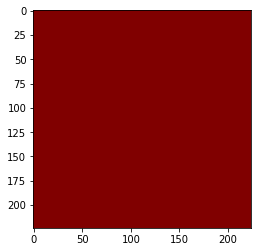

In [29]:
# from https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54
import cv2
import numpy as np
import tensorflow as tf

#IMAGE_PATH = './cat.jpg'
LAYER_NAME = last_layer
CAT_CLASS_INDEX = 0


img = x_cur
#img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
#img = tf.keras.preprocessing.image.img_to_array(img)

#model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)

grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CAT_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2GRAY), 0.5, cam, 1, 0)

cv2.imwrite(os.path.join(paths['root'],'gradCAM.png'), output_image)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 55, 55, 96)        11712     
_________________________________________________________________
batch_normalization_15 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_16 (Batc (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 384)      